### Globals

In [1]:
import datetime

tauri_onnx_models_directory = "../SonicSearch/src-tauri/onnx_models/"
file_timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = "laion/clap-htsat-unfused"

### Utilities

In [2]:
# Utilities
import time

def make_filename_or_dirname(filename, extension=None):
    extension = "" if extension is None else "." + extension.strip('.')
    filename = filename.strip('.').lstrip('/')
    return f'{tauri_onnx_models_directory}{filename}-{file_timestamp}{extension}'

# Inspect inputs and outputs
def get_shapes_in_nests(node, count=0):
    try:
        return str(node.shape)
    except:
        count += 1
        try:
            return ('\n' + '\t'*count).join([f'{key}: {get_shapes_in_nests(value)}' for key, value in node.items()])
        except:
            if isinstance(node, list):
                return ('\n' + '\t'*count).join([get_shapes_in_nests(n) for n in node])
            else:
                return str(node)
        
class QuickTimer():
    """hahaha"""
    _start = 0
    
    def start():
        QuickTimer._start = time.time()
    
    def stop():
        return time.time() - QuickTimer._start

## Load and Process Dummy Data

In [4]:
from transformers import AutoProcessor
from datasets import load_dataset

dataset = load_dataset("ashraq/esc50")
# NOTE: this dataset has a sampling_rate of 44100, whereas the model expects 48000. It works  dummy input, but don't use it for real data.
audio_samples = [data["array"] for data in dataset["train"]["audio"][0:32]]

input_texts = ["The sound of a moderate-length input string", "The sound of a slightly longer input string", "ok", 
              "Now this one is like super super super super suuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuper long!!! and has :) all these characters (f$#%)!"]

Repo card metadata block was not found. Setting CardData to empty.
It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [9]:

processor = AutoProcessor.from_pretrained(model_name, torchscript=True)
processed_inputs = processor(text=input_texts, audios=audio_samples, return_tensors="pt", padding=True)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
Traceback (most recent call last):
  File "/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined
Traceback (most recent call last):
  File "/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
NameError: name 'tensor' is not defined


Pre-processed audio:  (220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
Pre-processed text:  The sound of a moderate-length input string
	The sound of a slightly longer input string
	ok
	Now this one is like super super super super suuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuper long!!! and has :) all these characters (f$#%)!
Processed Model Inputs:  input_ids: torch.Size([4, 42])
	attention_mask: torch.Size([4, 42])
	input_features: torch.Size([32, 1, 1001, 64])
Processed text:  (tensor([[    0,   133,  2369,     9,    10,  7212,    12, 16096,  8135,  6755,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,   

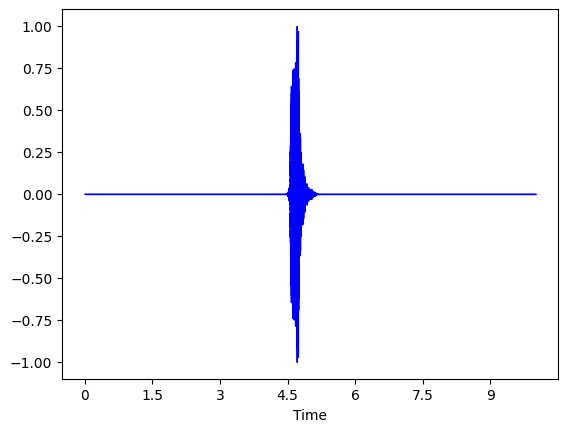

In [5]:
# Inspect Data
import librosa

print("Pre-processed audio: ", get_shapes_in_nests(audio_samples))
librosa.display.waveshow(audio_samples[0], color='b')
# 32 (batch) * 220500 (samples)

print("Pre-processed text: ", get_shapes_in_nests(input_texts))
# 4 (batch) * Variable-length string

print("Processed Model Inputs: ", get_shapes_in_nests(processed_inputs))

print("Processed text: ", get_shapes_in_nests((processed_inputs["input_ids"], processed_inputs["attention_mask"])))
print(processor.tokenizer)
# RobertaTokenizerFast
# input_ids: 4 (batch) * 42 (tokens), "1" is padding.
# attention_mask: 4 (batch) * 42 (tokens), "1" is for real tokens, "0" is for padding.

print("Processed Audio: ", get_shapes_in_nests(processed_inputs["input_features"]))
print(processor.feature_extractor)
# ClapFeatureExtractor - Mel Spectrogram + truncation + padding
# input_features: 32 (batch) * 1 (channel) * 1001 (?) * 64 (?)

### Save processor configs

In [33]:
processor.tokenizer.save_pretrained(make_filename_or_dirname("tokenizer"))
processor.feature_extractor.save_pretrained(make_filename_or_dirname("feature_extractor"))

['../SonicSearch/src-tauri/onnx_models/feature_extractor-20231106-235603/preprocessor_config.json']

## Full CLAP Model

### Load from pretrained

In [4]:
# Transformers Export
# https://huggingface.co/docs/transformers/v4.27.2/en/model_doc/clap

from transformers import ClapModel
model = ClapModel.from_pretrained(model_name)
model.eval()

### Run Full Model

In [5]:
print("Running model")
print("Inputs: ", get_shapes_in_nests(processed_inputs))
QuickTimer.start()
outputs = model(**processed_inputs)
print(f"Model finished in  {QuickTimer.stop()} seconds")
print("Outputs: ", get_shapes_in_nests(outputs))

Running model
Inputs:  input_ids: torch.Size([4, 42])
	attention_mask: torch.Size([4, 42])
	input_features: torch.Size([32, 1, 1001, 64])
Model finished in  1.8649959564208984 seconds
Outputs:  torch.Size([32, 4])
	torch.Size([4, 32])
	torch.Size([4, 512])
	torch.Size([32, 512])
	torch.Size([4, 42, 768])
	torch.Size([4, 768])
	torch.Size([32, 768, 2, 32])
	torch.Size([32, 768])


## Embedders-only (broken)

In [6]:
## Hack embedding functions as Modules

from transformers import ClapProcessor, ClapModel

# Hacky way to treat the get_*_features as Modules

class ClapModelGetTextFeatures(ClapModel):
    def __init__(self, model: ClapModel):
        super().__init__(config=model.config)

    def forward(self, input_ids, attention_mask, **kwargs):
        return super().get_text_features(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=False,
            output_hidden_states=False,
            **kwargs)
    
class ClapModelGetAudioFeatures(ClapModel):
    def __init__(self, model: ClapModel, processor: ClapProcessor):
        super().__init__(config=model.config)
        self.processor = processor

    def forward(self, audio_tensor, **kwargs):
        input_features = self.processor.feature_extractor(audio_tensor, return_tensors="pt", padding=True)['input_features']
        return super().get_audio_features(input_features=input_features, **kwargs)

### Coerce Embedder Inputs and Run Models

In [7]:
# Reshape inputs to match hacked Modules

import numpy
from torch import Tensor, from_numpy
import time

get_text_features_model = ClapModelGetTextFeatures(model)
tokenized_inputs = processor.tokenizer(input_texts, return_tensors="pt", padding=True)
text_features_dummy_input = (tokenized_inputs["input_ids"], tokenized_inputs["attention_mask"])

get_audio_features_model = ClapModelGetAudioFeatures(model, processor)
audio_features_dummy_input = audio_samples 

print("Running a forward pass on the Text Features Module")
print("Using Text Input of shape: ", get_shapes_in_nests(text_features_dummy_input))
start = time.time()
text_features_output = get_text_features_model.forward(*text_features_dummy_input)
print("Text Features Output Shape:", get_shapes_in_nests(text_features_output))
print("Text Features took: ", time.time() - start)

print("Running a forward pass on the Audio Features Module")
print("Using Audio Input of shape: ", get_shapes_in_nests(audio_features_dummy_input))
start = time.time()
audio_features_output = get_audio_features_model.forward(audio_features_dummy_input)
print("Audio Features Output Shape:", get_shapes_in_nests(audio_features_output))
print("Audio Features took: ", time.time() - start)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


Running a forward pass on the Text Features Module
Using Text Input of shape:  torch.Size([4, 42])
	torch.Size([4, 42])
Text Features Output Shape: torch.Size([4, 512])
Text Features took:  0.0975198745727539
Running a forward pass on the Audio Features Module
Using Audio Input of shape:  (220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
	(220500,)
Audio Features Output Shape: torch.Size([32, 512])
Audio Features took:  2.2357771396636963


### Export Embedder Models

In [8]:
# Onnx Export - Feature Embedding Only

from torch import onnx
import time

# Text Features
print("Exporting Text Features model to ONNX...")
start = time.time()
onnx.export(
    get_text_features_model,
    text_features_dummy_input,
    make_filename_or_dirname("laion_clap_htsat_unfused_get_text_features", "onnx"),
    export_params=True,
    input_names=["input_ids", "attention_masks"],
    output_names=["text_features"]
)
print("Exporting Text Features model to ONNX took: ", time.time() - start)

# Audio Features
print("Exporting Audio Features model to ONNX...")
start = time.time()
onnx.export(
    get_audio_features_model,
    audio_features_dummy_input,
    make_filename_or_dirname("laion_clap_htsat_unfused_get_audio_features", "onnx"),
    export_params=True,
    do_constant_folding=False,
    input_names=["audio_tensors"],
    output_names=["audio_features"]
)
print("Exporting Audio Features model to ONNX took: ", time.time() - start)

Exporting Text Features model to ONNX...
Exporting Text Features model to ONNX took:  2.6301209926605225
Exporting Audio Features model to ONNX...


RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: numpy.ndarray

## Export Full Model

In [9]:
# Onnx Export - Full Model

from torch import onnx
import time

onnx_inputs = (processed_inputs["input_ids"], processed_inputs["input_features"], False, processed_inputs["attention_mask"])
onnx_input_names = ["input_ids", "input_features", "is_longer", "attention_mask"]

onnx_output_names = []

print("Exporting model to ONNX...")
start = time.time()
onnx.export(
    model,
    onnx_inputs,
    make_filename_or_dirname("laion_clap_htsat_unfused", "onnx"),
    export_params=True,
    input_names=onnx_input_names,
    output_names=model(**processed_inputs, return_dict=True).keys(),
    
)
print("Exporting model to ONNX took: ", time.time() - start)

Exporting model to ONNX...


/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/transformers/models/clap/modeling_clap.py:870: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if time_length > spec_width or freq_length > spec_heigth:
/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/transformers/models/clap/modeling_clap.py:874: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if time_length < spec_width:
/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/transformers/models/clap/modeling_clap.py:878: TracerWarn

Exporting model to ONNX took:  31.832356214523315
